In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist')

Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz


In [31]:
# Model Inputs
def model_inputs(real_dim, noise_dim):
    inputs_real_ = tf.placeholder(tf.float32, shape=[None, real_dim], name='inputs_real')
    inputs_z_ = tf.placeholder(tf.float32, shape=[None, noise_dim], name='inputs_z')
    
    return inputs_real_, inputs_z_

In [32]:
def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

In [33]:
# Generator Network
def model_generator(z_input, out_dim, n_units=128, reuse=False, alpha=0.01):
    # used to reuse variables, name scope
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(z_input, n_units, activation=None)
        hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, out_dim, activation=None)
        outputs = tf.nn.tanh(logits)
        
        return outputs, logits

In [34]:
# Discriminator Network
def model_discriminator(input, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(input, n_units, activation=None)
        hidden_layer = leaky_relu(hidden_layer, alpha)
        
        logits = tf.layers.dense(hidden_layer, 1, activation=None)
        outputs = tf.nn.sigmoid(logits)
        
        return outputs, logits

In [36]:

input_size = 784
z_dim = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1
learning_rate = 0.001

In [37]:
tf.reset_default_graph()  # If we don't have this, as we call this block over and over, the graph gets bigger and bigger

graph = tf.Graph()
with graph.as_default():
    inputs_real, inputs_z = model_inputs(input_size, z_dim)
    
    g_outputs, g_logits = model_generator(inputs_z, input_size, n_units=g_hidden_size, reuse=False, alpha=alpha)
    
    d_outputs_real, d_logits_real = model_discriminator(inputs_real, n_units=d_hidden_size, reuse=False, alpha=alpha)
    d_outputs_fake, d_logits_fake = model_discriminator(g_outputs, n_units=d_hidden_size, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    t_vars = tf.trainable_variables()
    g_vars = [variable for variable in t_vars if 'generator' in variable.name]
    d_vars = [variable for variable in t_vars if 'discriminator' in variable.name]
    
    # Affected Variables with var_list
    d_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
    g_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)
    
    # Saving variables with var_list
    saver = tf.train.Saver(var_list=g_vars)

In [38]:

# Hyperparameters# Hyper 
n_epochs = 256
batch_size = 512
save_path = './saves/model.ckpt'

In [39]:
samples = []
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for b in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape([batch_size, 784])
            batch_images = batch_images * 2 - 1
            
            batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
            
            _ = sess.run(d_optimizer, feed_dict={inputs_real : batch_images, inputs_z : batch_z})
            _ = sess.run(g_optimizer, feed_dict={inputs_z : batch_z})
        loss_d, loss_g = sess.run([d_loss, g_loss], feed_dict={inputs_real : batch_images, inputs_z : batch_z})
        print('Epoch {} / {} Complete. D_Loss : {}, G_Loss : {}'.format(epoch+1, n_epochs, loss_d, loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=[16, z_dim])  # 16 Samples each epoch
        gen_samples, _ = sess.run(model_generator(inputs_z, input_size, reuse=True), feed_dict={inputs_z : sample_z})
        samples.append(gen_samples)
    print('Training Complete. Saving at {}...'.format(save_path))
    saver.save(sess, save_path)
    print('Saving Complete at {}.'.format(save_path))

Epoch 1 / 256 Complete. D_Loss : 0.3755921423435211, G_Loss : 3.4420111179351807
Epoch 2 / 256 Complete. D_Loss : 0.6241457462310791, G_Loss : 1.372650146484375
Epoch 3 / 256 Complete. D_Loss : 0.4006936550140381, G_Loss : 2.8167285919189453
Epoch 4 / 256 Complete. D_Loss : 0.36470597982406616, G_Loss : 3.57810640335083
Epoch 5 / 256 Complete. D_Loss : 0.3528003990650177, G_Loss : 3.9393811225891113
Epoch 6 / 256 Complete. D_Loss : 0.346934974193573, G_Loss : 4.296825408935547
Epoch 7 / 256 Complete. D_Loss : 0.3408134877681732, G_Loss : 4.671425819396973
Epoch 8 / 256 Complete. D_Loss : 0.3435607850551605, G_Loss : 4.4240312576293945
Epoch 9 / 256 Complete. D_Loss : 0.3418147563934326, G_Loss : 4.694554328918457
Epoch 10 / 256 Complete. D_Loss : 0.3412039875984192, G_Loss : 4.546547889709473
Epoch 11 / 256 Complete. D_Loss : 0.3464575707912445, G_Loss : 4.478977203369141
Epoch 12 / 256 Complete. D_Loss : 0.42954444885253906, G_Loss : 2.546236753463745
Epoch 13 / 256 Complete. D_Loss :

Epoch 101 / 256 Complete. D_Loss : 1.201629638671875, G_Loss : 1.518815517425537
Epoch 102 / 256 Complete. D_Loss : 2.384387493133545, G_Loss : 0.9346526861190796
Epoch 103 / 256 Complete. D_Loss : 1.5228219032287598, G_Loss : 1.482276439666748
Epoch 104 / 256 Complete. D_Loss : 1.499014973640442, G_Loss : 1.6010692119598389
Epoch 105 / 256 Complete. D_Loss : 1.035128116607666, G_Loss : 2.549715757369995
Epoch 106 / 256 Complete. D_Loss : 0.993428647518158, G_Loss : 2.9874985218048096
Epoch 107 / 256 Complete. D_Loss : 0.8715392351150513, G_Loss : 2.3456530570983887
Epoch 108 / 256 Complete. D_Loss : 1.1480437517166138, G_Loss : 1.6879827976226807
Epoch 109 / 256 Complete. D_Loss : 1.2062329053878784, G_Loss : 1.6803803443908691
Epoch 110 / 256 Complete. D_Loss : 1.4195091724395752, G_Loss : 1.3522300720214844
Epoch 111 / 256 Complete. D_Loss : 0.8750068545341492, G_Loss : 2.652843475341797
Epoch 112 / 256 Complete. D_Loss : 1.0267934799194336, G_Loss : 2.17360258102417
Epoch 113 / 256

Epoch 200 / 256 Complete. D_Loss : 1.0034666061401367, G_Loss : 1.5209832191467285
Epoch 201 / 256 Complete. D_Loss : 1.1751991510391235, G_Loss : 1.6098158359527588
Epoch 202 / 256 Complete. D_Loss : 0.9906577467918396, G_Loss : 1.9645248651504517
Epoch 203 / 256 Complete. D_Loss : 0.9978313446044922, G_Loss : 2.01873779296875
Epoch 204 / 256 Complete. D_Loss : 1.0089908838272095, G_Loss : 1.9931023120880127
Epoch 205 / 256 Complete. D_Loss : 1.0742604732513428, G_Loss : 1.9373327493667603
Epoch 206 / 256 Complete. D_Loss : 1.099588394165039, G_Loss : 1.729821801185608
Epoch 207 / 256 Complete. D_Loss : 1.5765233039855957, G_Loss : 1.2976787090301514
Epoch 208 / 256 Complete. D_Loss : 1.0714058876037598, G_Loss : 1.710937738418579
Epoch 209 / 256 Complete. D_Loss : 0.9988543391227722, G_Loss : 2.1372218132019043
Epoch 210 / 256 Complete. D_Loss : 1.2820186614990234, G_Loss : 1.468940019607544
Epoch 211 / 256 Complete. D_Loss : 1.3184564113616943, G_Loss : 1.5901484489440918
Epoch 212 

In [40]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape([28, 28]), cmap='Greys_r')
        
    
    return fig, axes

Epoch 0 Samples : 


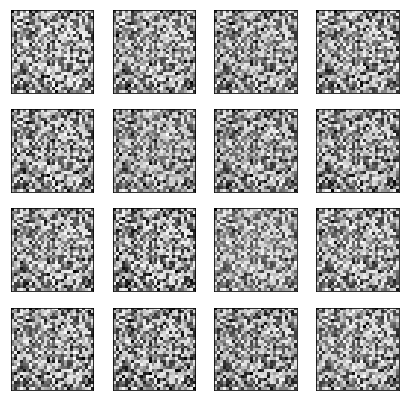

Epoch 10 Samples : 


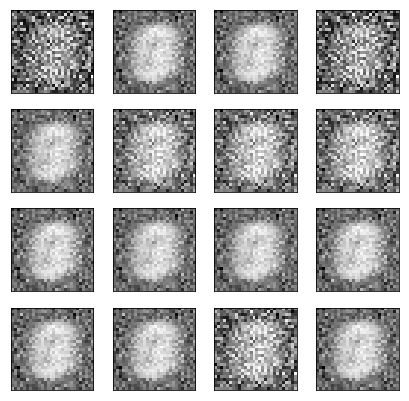

Epoch 20 Samples : 


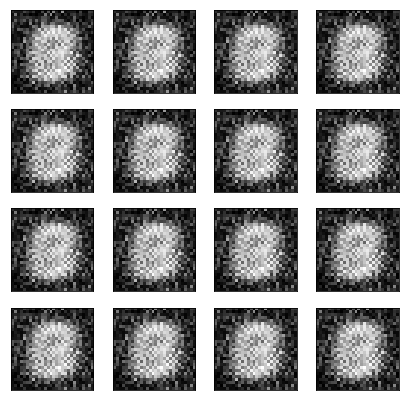

Epoch 30 Samples : 


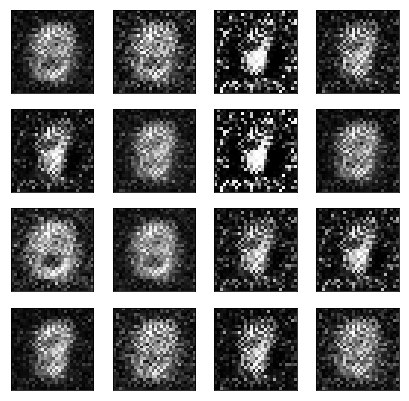

Epoch 40 Samples : 


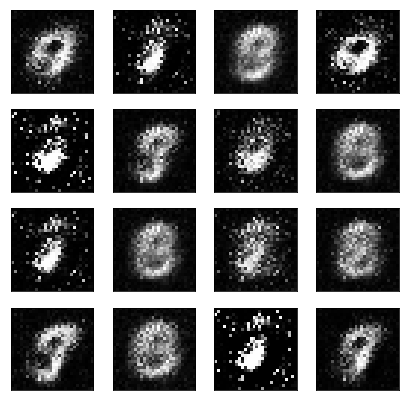

Epoch 50 Samples : 


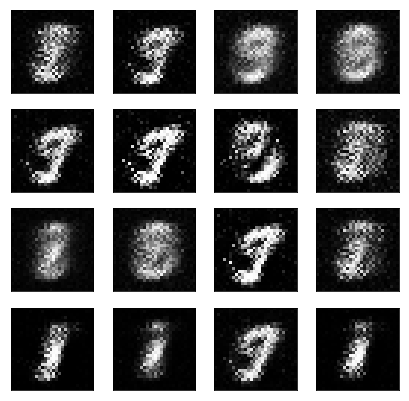

Epoch 60 Samples : 


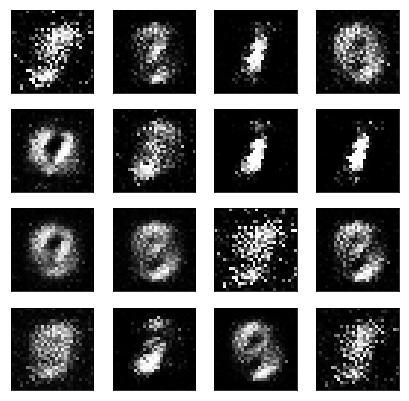

Epoch 70 Samples : 


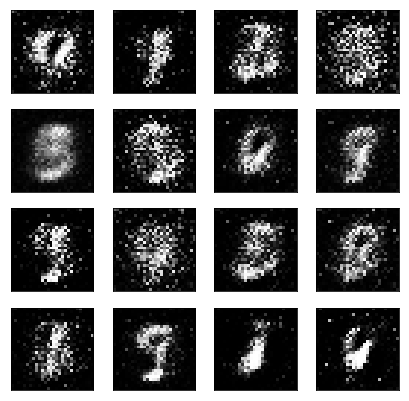

Epoch 80 Samples : 


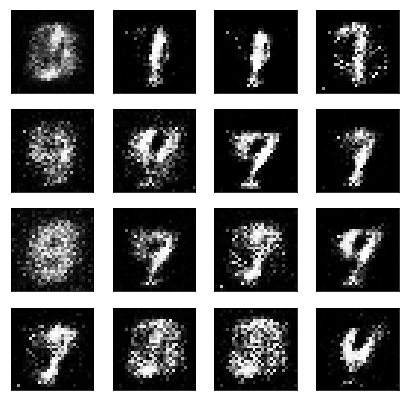

Epoch 90 Samples : 


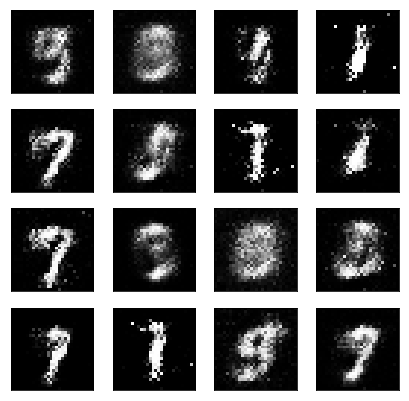

Epoch 100 Samples : 


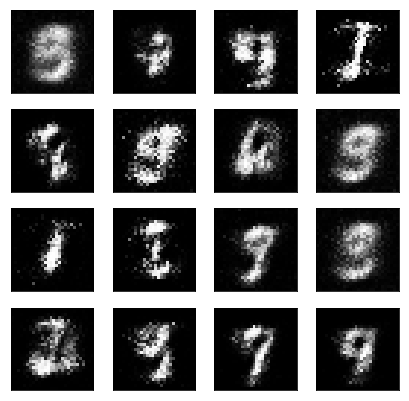

Epoch 110 Samples : 


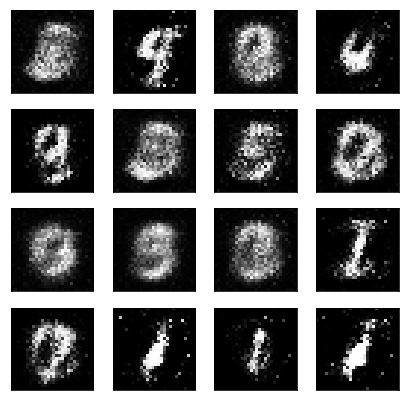

Epoch 120 Samples : 


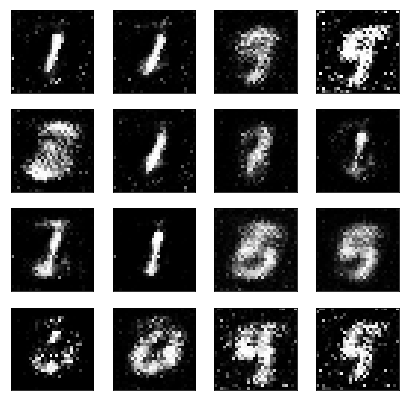

Epoch 130 Samples : 


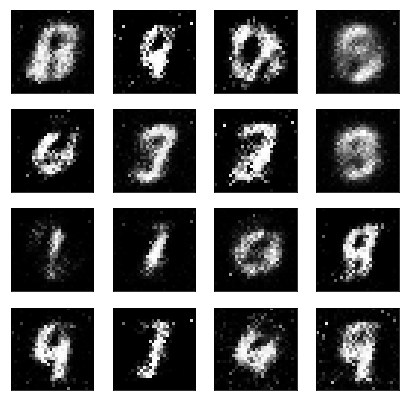

Epoch 140 Samples : 


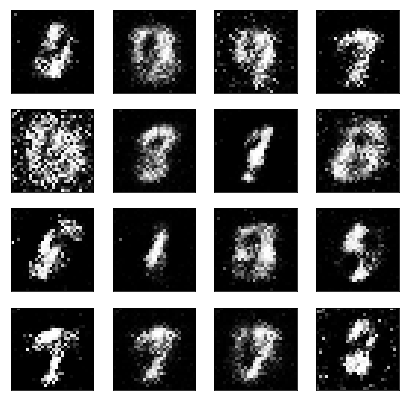

Epoch 150 Samples : 


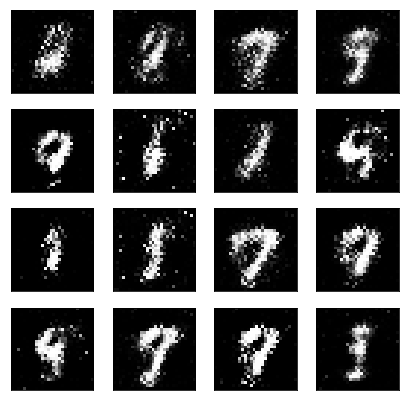

Epoch 160 Samples : 


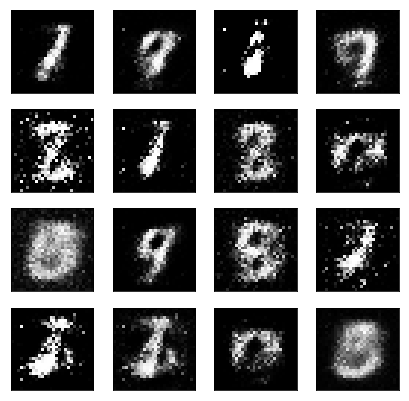

Epoch 170 Samples : 


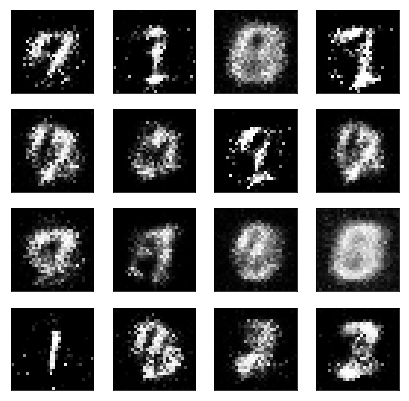

Epoch 180 Samples : 


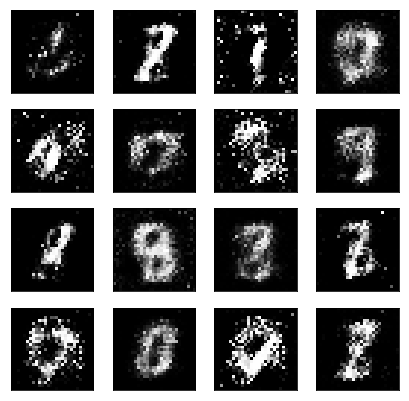

Epoch 190 Samples : 


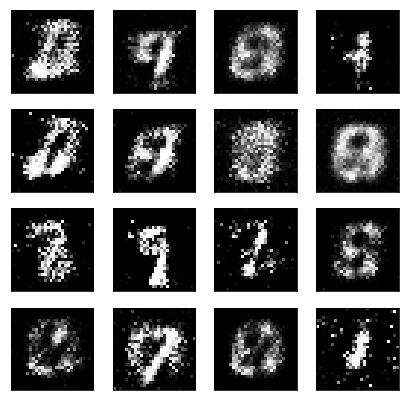

Epoch 200 Samples : 


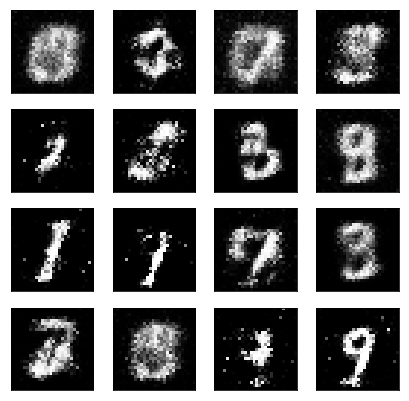

Epoch 210 Samples : 


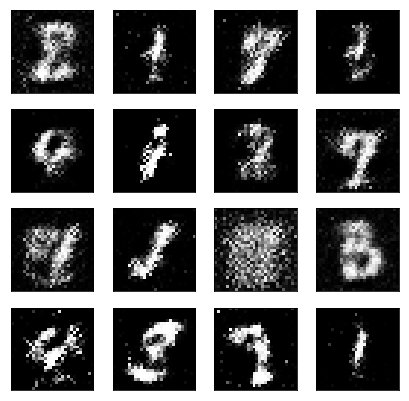

Epoch 220 Samples : 


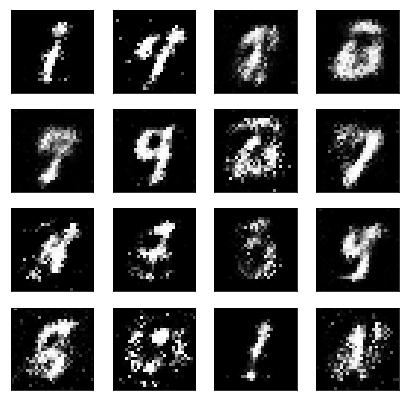

Epoch 230 Samples : 


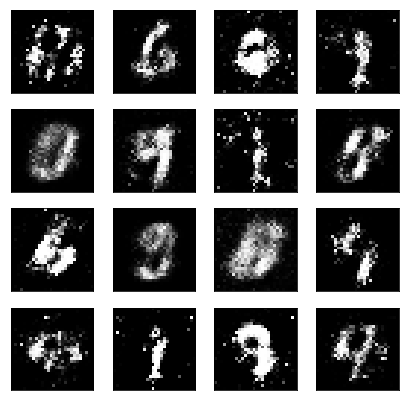

Epoch 240 Samples : 


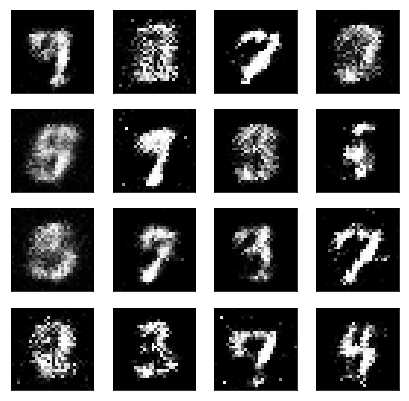

Epoch 250 Samples : 


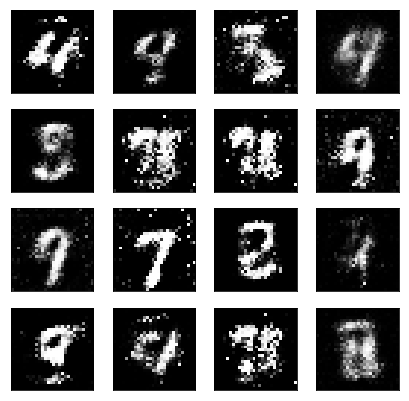

In [41]:
for i in range(0, n_epochs, 10):
    print('Epoch {} Samples : '.format(i))
    plt.show(view_samples(i, samples))